In [255]:
#imports 
import mne
import numpy as np
import pandas as pd
import os
import glob
from matplotlib import pyplot as plt
import sys

import seaborn as sns
from itertools import product as prod

In [286]:
import time

In [290]:

class eeg_dynamic_read:
    def __init__(self, file, montageFile):
        self.file=file
        self.montage=montageFile
    
    def read_eeg(self):
        eeg_type='read_'+self.file.split('.')[-1]
        method=getattr(self, eeg_type, lambda: 'Invalid Type')
        return method()
        
    def read_cnt(self):
        return mne.io.read_raw_cnt(self.file,self.montage)



class subject:
    def __init__(self, ID, data, montage, eventIDs):
        """
        Subject class the contain individual subject data and the methods necessary to 
        do all within subjects processing and analyses
        
        ID: (String/Int) - Subject Indetifier
        data : (String) - name of data file - automatically loaded into mne with dynamic read
        montage : (String) - name of monatage file automatically loaded into mne with dynamic read
        eventIDs : (Dict) - mapping of event names to event codes
        
        """
        self.ID=ID
        self.data=eeg_dynamic_read(data, montage).read_eeg()
        self.events=mne.find_events(self.data)
        self.event_ID=eventIDs
        self.sample_rate=self.data.info['sfreq']
        
        #data stores for sample data
        #electorde x event code x event x time
        self.sample_channels=None
        self.sample_store=None
        self.sample_events=None
        
        #bootstrap dependedant struture
        # boot shape x random Draws
        self.boot_store=None
    
    def get_item_eeg(self, tmin=-.2, tmax=.8, baseline=(None,0.0), 
                         events=None, chans=[], average=False, store=False):
        
        """function epochs the data and returns an electrode x event code x event x sample array, with option
        to store in the sample_store attribute.
          
        tmin : (float/int) - time in seconds to begin epoch
        tmax : (float/int) - time in seconds to end epoch
        baseline : (tuple of ints) - beginning, end of baseline period
        events : (list of strings) - list of events names to pull out
        chans : (list of strings) - list of channel names to get data from
        average : (boolean) : whether or not to average the data
        store : (boolean) : whether or not to store data in the class attribute
        
        """
        
        if not events:
            raise 'Event of Interest Must be specified'
        
        erp=mne.Epochs(self.data, events=self.events, event_id=self.event_ID, tmin=tmin,
                    tmax=tmax, baseline=baseline, preload=True)
        
        #swap axes 0,1
        if average:
            ret=erp[event].average(picks=chans)
        else:
            ret=np.array([erp[event].pick_channels(chans).get_data() for event in events])
            
            #strutuces the array
            ret=np.swapaxes(np.swapaxes(ret, 0, 2), 1, 2)
        
        #option to store the data as part of the class
        #or return in
        if store:
            self.sample_channels=chans
            self.sample_store=ret
        else:   
            return ret
    
        
    def random_draw(self, array, nDraws=100, sampleSize=10, replacement=True):
        '''
        returns an array of boot-strapped means along the last axis of the passed array
        
        array : (nD array)
        nDraws : (int) - number of means to generate
        sampleSize : (int) - number of sample to take on each draw
        replacment : (boolean) - replacement for draws
        '''
        
        if not (sampleSize < array.shape[len(array.shape)-1]) and not replacement:
            raise "Sampling without replacement is limited to N-1 samples. Check sample store array for size"
        
        def _make_index(shape):
            '''takes in array shape tuple and out puts a list of all 
            index combinations'''
            ind=list(map(range, shape))
            ind=list(map(list, ind))
            return list(prod(*ind))
        
        #get the necessary array shape for initiating the matrix
        arrShape=list(array.shape)[:-1]
        arrShape.extend([nDraws])
        
        #intiate thats shape x random draw
        boot_dist=np.zeros(arrShape)
        
        for idx in _make_index(arrShape):
            #pull out random indexes and slice the array
            rand_idx=np.random.choice(array.shape[-1], size=sampleSize, replace=replacement)
            
            #we have to pull out all but the last element of the idx tuple so that we're drawing
            #from the correct groups
            pulled_data=array[idx[:-1]]
            boot_dist[idx]=np.mean(pulled_data[rand_idx])
        
        return boot_dist
        
    
    def get_mean_amp(self, flatten_axes=None, boots=200, samples=10):
        '''get the mean amplitude accross the epoch'''
        mean_amp=np.mean(self.sample_store, (len(self.sample_store.shape)-1))
        
        if flatten_axes:
            mean_amp=mean_amp.reshape(*mean_amp.shape[:flatten_axes], -1)
        self.boot_store= self.random_draw(mean_amp,nDraws=boots, sampleSize=samples)
    
    def peak_latency(self):
        pass
                                                             
    
    def plot(self, data='boot_store', axis=0, colors='magma', xlabel='Channels', xticks=None, jits=True):
        '''plots the boot-strapped data along the axis of interest
        
        axis : (int) - axis to plot the data along
        colors : (String) - name of seaborn color palette for ploting
        
        '''
        try:
            #turn to 2d array along the desired axis
            plot_boot=getattr(self, data).reshape(getattr(self, data).shape[axis], -1)
            
            
            #take the mean of the data points across desired axis 
            #if not the boot strapped data
            if data !='boot_store':
                plot_boot=np.mean(plot_boot)
            
            #transpse the array for plotting
            plot_boot=(plot_boot.T) *1e6
        
            plter=sns.stripplot(data=plot_boot, palette=colors, jitter=jits)
            plter.set(xticklabels=xticks, xlabel=xlabel, ylabel='MicroVolts')
        
        except:
            raise 
        
        
class eeg_power: 
    def __init__(self, fileDir=None,  dataType=None, montage=None, eventMap=None):
        
        '''class that serves as the group level data type
        
        fileDir : (String) - file path (organized to BIDs specs)
        dataType : (String) - type of eeg file being loaded in
        montage : (Stinge) - path for montage file
        eventMap : (Dict) - dictionary with Key, Value pairs that specify event name, event code
        
        '''
        if not eventMap:
            raise 'Please specify event code meanings'
        if not montage:
            raise 'Please specify a list or specific set of montages for subjects'
        if not dataType:
            raise 'EEG file type must be specified'
       
        #search the whole directory tree for anything with the 
        #specified data type
        self.directory=fileDir
        self.files=glob.glob(os.path.join(fileDir, '**', 'EEG', ('*' + dataType)))                            
        self.montage=montage
        self.data=None
        self.eventMap=eventMap
        
        #stores for bootsraps
        #subject x shape x draws
        self.boot_store=None
        self.subsets={}
    
    def get_name(self, fstring):
        '''gets subject ID from file string'''
        return fstring.split(os.sep)[-3]
        
    def load_data(self):
        '''load method after intial init, this will give us the flexibility to restart after node subsetting if we need to'''
        dats=[subject(ID=self.get_name(file),data=file, montage=self.montage, eventIDs=self.eventMap) for file in self.files]
        self.data=dats
    
    
    def random_draw(self, array, nDraws=100, sampleSize=10, replacement=True):
        '''
        returns an array of boot-strapped means along the last axis of the passed array
        
        array : (nD array)
        nDraws : (int) - number of means to generate
        sampleSize : (int) - number of sample to take on each draw
        replacment : (boolean) - replacement for draws
        '''
        
        if not (sampleSize < array.shape[len(array.shape)-1]) and not replacement:
            raise "Sampling without replacement is limited to N-1 samples. Check sample store array for size"
        
        def _make_index(shape):
            '''takes in array shape tuple and out puts a list of all 
            index combinations'''
            ind=list(map(range, shape))
            ind=list(map(list, ind))
            return list(prod(*ind))
        
        #get the necessary array shape for initiating the matrix
        arrShape=list(array.shape)[:-1]
        arrShape.extend([nDraws])
        
        #intiate thats shape x random draw
        boot_dist=np.zeros(arrShape)
        
        for idx in _make_index(arrShape):
            #pull out random indexes and slice the array
            rand_idx=np.random.choice(array.shape[-1], size=sampleSize, replace=replacement)
            
            #we have to pull out all but the last element of the idx tuple so that we're drawing
            #from the correct groups
            pulled_data=array[idx[:-1]]
            boot_dist[idx]=np.mean(pulled_data[rand_idx])
        
        return boot_dist
    
    
    def epoch_subjects(self,tmin=-.2, tmax=.8, baseline=(None,0.0), 
                         event=None, chans=[], average=False, store=False):
       
        #sets what we pulled out for the analyses so we can 
        self.subsets['electrode']=chans
        self.subsets['eventName']=event
        
        #creates the epoch data for each subject
        [s.get_item_eeg(tmin=tmin, tmax=tmax, baseline=baseline,events=event, chans=chans, average=average, store=store) for s in self.data]
        
        
    def mean_amplitude(self, flatten_axes=None, boots=200, lvl1_samples=10, lvl2_samples=300):
        
        #self.epoch_subjects(tmin=tmin, tmax=tmax, baseline=baseline, event=event, chans=chans, store=True)
        
        #boot each subject in turn
        [s.get_mean_amp(flatten_axes=flatten_axes, boots=boots, samples=lvl1_samples) for s in self.data]
        
        
        #second level boot-straping
        self.boot_store=np.array([self.random_draw(sub.boot_store, nDraws=boots, sampleSize=lvl2_samples) for sub in self.data])
        print (self.boot_store.shape)            
    
    def plot_boots(self, data='boot_store', data_key='electrode', col_wrap=5, individuals=True, figureSize=(20, 20), cols='Spring',
                  title=None, save=False):
        
        key2axes={'subject':0, 'electrode':1, 'eventName':2, 'event':3, 'time':4}
         
        if individuals: 
            #reset col_wrap if its not needed so that we don't
            #make extra plots
            col_wrap = col_wrap if len(self.data) > col_wrap else len(self.data)
            
            rows=int(np.ceil(len(self.data)/col_wrap))
            
            plots, axs = plt.subplots(rows,col_wrap,figsize=figureSize)  
            
            axs=axs.ravel()
            
            for i in range(len(axs)):
                plt.sca(axs[i])
                #axes key gets shifted down one when plotting from subject class methods
                self.data[i].plot(data=data, axis=key2axes[data_key]-1, xticks=self.subsets[data_key],colors=cols, jits=False)
                #self.data[i].plot(data='sample_store',axis=1, colors='Blues')
                plt.title(self.data[i].ID)
                
        else:
            try:
                #turn to 2d array along the desired axis
                plot=getattr(self, data).reshape(getattr(self, data).shape[key2axes[data_key]], -1)
            
            
                #take the mean of the data points across desired axis 
                #if not the boot strapped data
                if data !='boot_store':
                    plot=np.mean(plot)
            
                #transpse the array for plotting
                plot=(plot.T) *1e6
                
                print (plot.shape)
                
                plter=sns.stripplot(data=plot, palette=cols, jitter=True)
                plter.set(xticklabels=self.subsets[data_key], xlabel=data_key, ylabel='MicroVolts')
                plt.title(title)
            
            except:
                raise 
        
        if save:
            if not os.path.exists(os.path.join(self.directory, 'Figures')):
                os.mkdir((os.path.join(self.directory, 'Figures')))
            
            plt.savefig((os.path.join(self.directory, 'Figures', data_key + '.png')))
                      
                        
        
       

In [291]:
direct='C:/Users/Phil/Box Sync/Classes/PSC_290_Final/data'
mont=os.path.join(direct, 'BP64_acti_64rows.sfp')

#event mappings for the test data
evMaps={'Test': 1, 'Test2': 2, 'Test3': 3, 'Test48': 48, 'Test77': 77, 'Test88':88, 'Test100': 100, 'Test200' : 200}

The graph shows test output for channel Fz at event code 2. Data are baselined in the interval -200ms - 0ms prior to stimulus onset. max time is 800ms

In [292]:
%%capture

start = time.time()

dats=eeg_power(fileDir=direct, dataType='cnt', montage=mont, eventMap=evMaps)
dats.load_data()

dats.epoch_subjects(tmin=-.2, tmax=.8, baseline=(None,0.0), 
                             event=['Test', 'Test2', 'Test3'], chans=['Fp1', 'Fp2', 'F7', 'F3', 'Fz','F4','F8','FC5','FC1','FC2','FC6'], store=True)
dats.mean_amplitude(flatten_axes=2, boots=300, lvl1_samples=10)
end = time.time()

In [289]:
print (end-start)

48.948118448257446


(29700, 3)


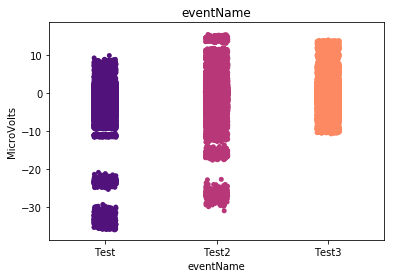

In [285]:
dats.plot_boots(data_key='eventName', col_wrap=3, individuals=False, cols='magma', save=True)

In [275]:
29700/9/11

300.0

(11, 2, 200)

In [206]:
sys.getsizeof(dats)

32